# Installation

In [ ]:
# Clone
!git clone https://github.com/maryfeizabad/TranSalNet.git
%cd TranSalNet

Cloning into 'TranSalNet'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 9), reused 58 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 3.14 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/TranSalNet


In [ ]:
!pwd

/content/TranSalNet


In [ ]:
!pip install torch
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install tqdm
!pip install pillow
!pip install image
!pip install torchvision
#!pip install pytorch #new, comment out because you dont need
!pip install torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data prepare for fine-tuning and training:
│ dataset/
├── train_ids.csv
├── val_ids.csv
├── train/
│   ├── train_stimuli/
│   │   ├── ......
│   ├── train_saliency/
│   │   ├── ......
│   ├── train_fixation/
│   │   ├── ......
├── val/
│   ├── val_stimuli/
│   │   ├── ......
│   ├── val_saliency/
│   │   ├── ......
│   ├── val_fixation/
│   │   ├── ......



SyntaxError: invalid character '│' (U+2502) (<ipython-input-18-895e46f2edac>, line 2)

# Load pretrained_models and Test

In [ ]:
!nvidia-smi


Sat Oct 12 18:22:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import torch
import cv2
import numpy as np
import subprocess
from torchvision import transforms, utils, models
import torch.nn as nn
from tqdm import tqdm
from utils.data_process import preprocess_img, postprocess_img
from PIL import Image
from TranSalNet_Res import TranSalNet
from torch.nn.functional import interpolate

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


↑↑↑ Set flag=1 to load TranSalNet_Dense,set flag=0 to load TranSalNet_Res.

↓↓↓ Load the model and pre-trained parameters.

In [ ]:
!pwd

/content/TranSalNet


In [ ]:
def download_weights():
    weights = {
        'pretrained_models/TransSalNet_Res.pth': '1c0zfN5vknS57y952bwkgJ03SPK9VzZZN',
        'pretrained_models/resnet50-0676ba61.pth': '1nO0GpqelLx6CPjsAunbIs-yEC-jejEXW'

    }
    for weight_path, file_id in weights.items():
        if not os.path.exists(weight_path):
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            print(f"Downloading {weight_path}...")
            subprocess.run(['gdown', '--id', file_id, '-O', weight_path], check=True)
        else:
            print(f"{weight_path} already exists.")

# Download weights
download_weights()

In [ ]:
model = TranSalNet()


/content/TranSalNet/utils/resnet.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r'pretrained_models/resnet50-0676ba61.pth')


!**New code to troubleshoot**





In [ ]:
!ls /content/TranSalNet/pretrained_models/

resnet50-0676ba61.pth  TransSalNet_Res.pth


TransSalNet_Dense does not exist, change weights used to TransSalNet_Res.pth

In [ ]:

model.load_state_dict(torch.load(r'pretrained_models/TransSalNet_Res.pth')) #new




<ipython-input-51-9ec96d4fc775>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'pretrained_models/TransSalNet_Res.pth'))


<All keys matched successfully>

In [ ]:
model.eval()

↓↓↓ Get the test image, feed it into the model, and get a result.

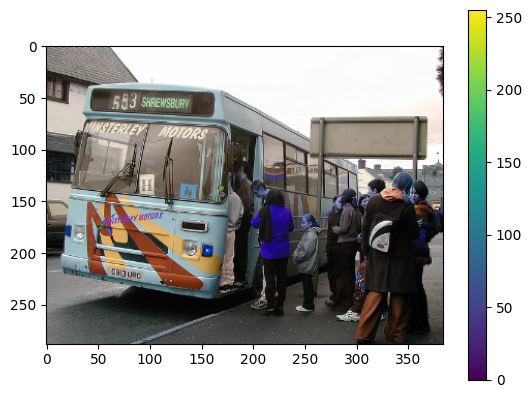

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

test_img = r'example/COCO_val2014_000000005107.jpg'
img = preprocess_img(test_img)  # Padding and resizing input image into 384x288

plt.imshow(img)
plt.colorbar()
plt.show()

This step is not ruining the image

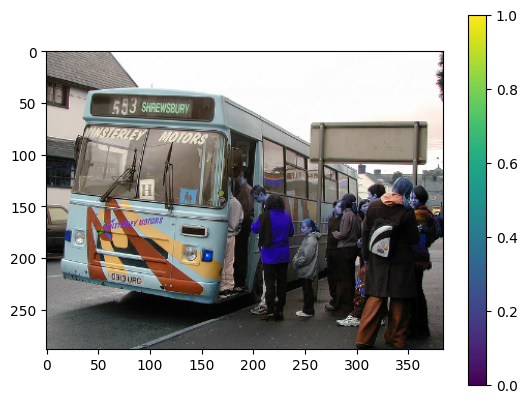

In [ ]:
img = np.array(img) / 255.
img = np.expand_dims(np.transpose(img, (2, 0, 1)), axis=0)

# Reshape for visualization
img_vis = np.transpose(img.squeeze(), (1, 2, 0))

plt.imshow(img_vis)
plt.colorbar()
plt.show()


This step is not ruining the image

In [ ]:
img = torch.from_numpy(img).type(torch.cuda.FloatTensor).to(device)
# Check device
print("Tensor device:", img.device)



Tensor device: cuda:0


If  Tensor device: cuda:0 means its on first gpu

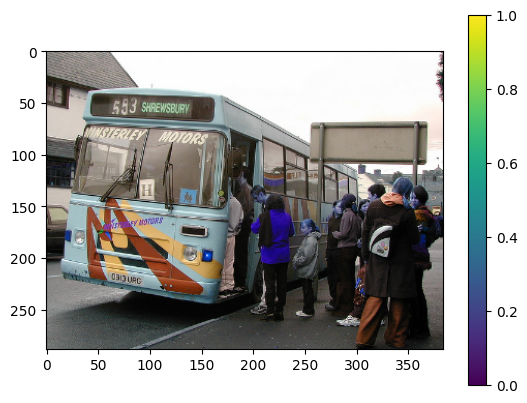

In [ ]:
# Reshape for visualization
img_vis = img.squeeze().cpu().detach().numpy()
img_vis = np.transpose(img_vis, (1, 2, 0))

plt.imshow(img_vis)
plt.colorbar()
plt.show()

The previous step did not ruining the image

In [ ]:
model = model.to(device)  # Ensure the model is on the GPU


# Check if model parameters are on GPU
for param in model.parameters():
    print(param.device)
    break


cuda:0


cuda: 0 means its on a GPU

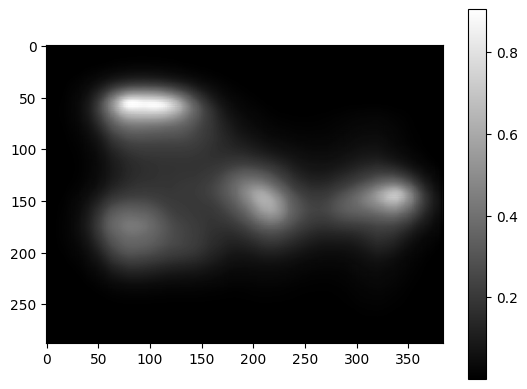

In [ ]:
pred_saliency = model(img)

# Visualize the intermediate output
pred_saliency_np = pred_saliency.squeeze().cpu().detach().numpy()
plt.imshow(pred_saliency_np, cmap='gray')
plt.colorbar()
plt.show()

In the above the salient mapping is being done, the main issues were not loading the weights. Can you load the TransSalNet_Dense.pth weights? they are not being downloaded. Check on the left hand side, click on the folder, and go into pretrained_models.

Below is the final step of the original code

In [ ]:

toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency.squeeze())
pred_saliency = postprocess_img(pic, test_img)  # Restore the image to its original size as the result
cv2.imwrite(r'example/result.png', pred_saliency, [int(cv2.IMWRITE_JPEG_QUALITY), 100])  # Save the result
print('Finished, check the result at: {}'.format(r'example/result.png'))

Finished, check the result at: example/result.png


**!End of new code to troubleshoot**

Below is the original code. It works now.

In [ ]:
test_img = r'example/COCO_val2014_000000005107.jpg'

img = preprocess_img(test_img) # padding and resizing input image into 384x288
img = np.array(img)/255.
img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
img = torch.from_numpy(img)
img = img.type(torch.cuda.FloatTensor).to(device)
model = model.to(device) #new!

pred_saliency = model(img)
toPIL = transforms.ToPILImage()
pic = toPIL(pred_saliency.squeeze())

pred_saliency = postprocess_img(pic, test_img) # restore the image to its original size as the result

cv2.imwrite(r'example/result.png', pred_saliency, [int(cv2.IMWRITE_JPEG_QUALITY), 100]) # save the result
print('Finished, check the result at: {}'.format(r'example/result.png'))

Finished, check the result at: example/result2.png
